# Chipotle Survey Customer Segmentation Analysis
Kyle Pelham, kyleplhm@gmail.com

## Introduction

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate

In [58]:
# Read in chipotle survey data 
df = pd.read_csv('Data\chipotle survey.csv')

# Drop rows and columns that are blank due to survey formatting issues
df = df.iloc[0:357,0:25]

# Preview data with info()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   top1                  357 non-null    object 
 1   wom                   357 non-null    float64
 2   sm                    357 non-null    float64
 3   walk                  357 non-null    float64
 4   billboard             357 non-null    float64
 5   patronage             357 non-null    float64
 6   importantconvenience  338 non-null    float64
 7   importantvariety      333 non-null    float64
 8   importantprice        334 non-null    float64
 9   importanthealthy      335 non-null    float64
 10  importanttaste        332 non-null    float64
 11  importantambience     335 non-null    float64
 12  chipotleconvenient    334 non-null    float64
 13  chipotlevariety       333 non-null    float64
 14  chipotleprice         336 non-null    float64
 15  chipotlehealthy       3

In [59]:
# Find number of NA values in each column
df.isna().sum()

top1                     0
wom                      0
sm                       0
walk                     0
billboard                0
patronage                0
importantconvenience    19
importantvariety        24
importantprice          23
importanthealthy        22
importanttaste          25
importantambience       22
chipotleconvenient      23
chipotlevariety         24
chipotleprice           21
chipotlehealthy         27
chipotletaste           23
chipotleambience        24
female                  14
age                     14
income                  14
plan                    14
spending                16
buylocal                17
healthyimportanttome    16
dtype: int64

<AxesSubplot:>

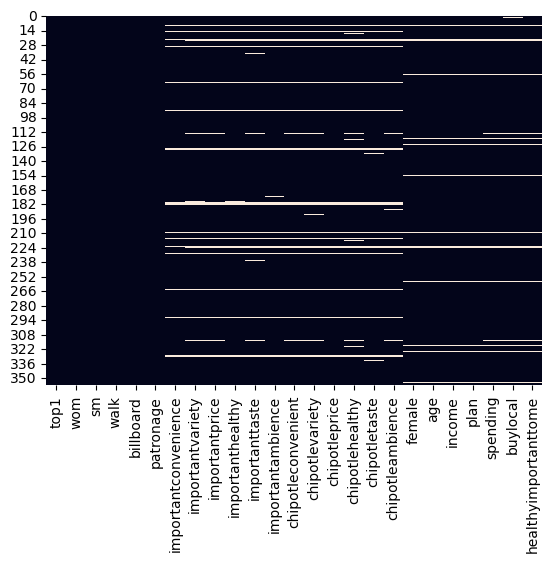

In [60]:
# Create heatmap to visualize NA values in each column
sns.heatmap(df.isna(), cbar=False)

In [61]:
# Drop rows with NA values because k-means clustering cannot handle NA values and imputing them could skew the data
df.dropna(inplace=True)

# shape of cleaned data after dropping NA values
df.shape

(313, 25)

In [62]:
# Print unique values in each column for top1 column
pd.Series(df['top1'].unique()).sort_values()

9               Applebees
7                   Arbys
20            Chick fil a
15             Chick fila
3             Chick-Fil-A
8             Chick-fil-a
37                Chipole
4                Chipolte
1                Chipotle
18          El Pollo Loco
13                 Eppies
0                In-n-out
12    In-n-out Kebob Shop
31           Jason's Deli
33            Jasons Deli
5                     KFC
25             MacDonalds
6               McDonalds
36              Mcdonalds
11                Outback
2                  Panera
19           Panera bread
30              Pizza Hut
14          Pizza express
17              Starbucks
21                Sub Way
28                 Subway
27              Taco Bell
29             The Market
24                Wendy's
22                 Wendys
23                  arbys
32            burger king
26              chickfila
16             chik-fil-a
34              mcdonalds
10                 panera
35           panera bread
dtype: objec

In [63]:
# Replace all values in top1 column that contain variations of restaurants with the correct restaurant name
df['top1'] = df['top1'].str.replace('(?i)chic?k[-_ ]?fil[-_ ]?[aA]', "Chick-fil-A", regex= True)

df['top1'] = df['top1'].str.replace('(?i)chip?o?l?t?l?e', "Chipotle", regex= True)

df['top1'] = df['top1'].str.replace('(?i)ma?cdonald[-_ ]?[sS]', "McDonald's", regex= True)

df['top1'] = df['top1'].str.replace('(?i)panera(?:\s?bread)?', "Panera Bread", regex= True)

df['top1'] = df['top1'].str.replace('(?i)sub[-_ ]?way', "Subway", regex= True)

df['top1'] = df['top1'].str.replace("(?i)arby'?s", "Arby's", regex= True)

df['top1'] = df['top1'].str.replace("(?i)wendy'?s", "Wendy's", regex= True)

df['top1'] = df['top1'].str.replace("(?i)jason'?s\s?deli", "Jason's Deli", regex= True)

# Fix the capitalization of the values in the top1 column except for apostrophes for McDonald's, Arby's and Wendy's
df['top1'] = df['top1'].str.title().str.replace("'S",  "'s", regex= True)


# Print unique values in each column for top1 column to confirm changes
pd.Series(df['top1'].unique()).sort_values()

7               Applebees
6                  Arby's
20            Burger King
3             Chick-Fil-A
1                Chipotle
13          El Pollo Loco
10                 Eppies
0                In-N-Out
9     In-N-Out Kebob Shop
19           Jason's Deli
4                     Kfc
5              Mcdonald's
8                 Outback
2            Panera Bread
11          Pizza Express
18              Pizza Hut
12              Starbucks
14                 Subway
16              Taco Bell
17             The Market
15                Wendy's
dtype: object

In [64]:
# Initialize StandardScaler as scaler
scaler = StandardScaler()

# Fit scaler to numerical columns
df_scaled = scaler.fit_transform(df.drop('top1', axis=1))

# Perform PCA on numerical columns
pca = PCA(n_components=2)

# Fit PCA to numerical columns
pca.fit(df_scaled)

# Transform numerical columns with PCA
pca_transformed = pca.transform(df_scaled)

# Create dataframe with PCA components
pca_df = pd.DataFrame(pca_transformed, columns=['PCA1', 'PCA2'])

# View how much each variable contributes to the first three principal components
components = pd.DataFrame(pca.components_, columns = df.drop('top1', axis=1).columns ,index = ['PCA1', 'PCA2']).transpose()
components


,PCA1,PCA2
wom,-0.061706,-0.356166
sm,0.025426,0.038712
walk,0.017014,0.363352
billboard,-0.082525,0.145029
patronage,0.105851,-0.019325
importantconvenience,-0.229537,-0.064514
importantvariety,-0.286483,-0.121365
importantprice,-0.229620,-0.151210
importanthealthy,-0.249865,-0.258858
importanttaste,-0.093490,-0.253368


c:\Users\kylep\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


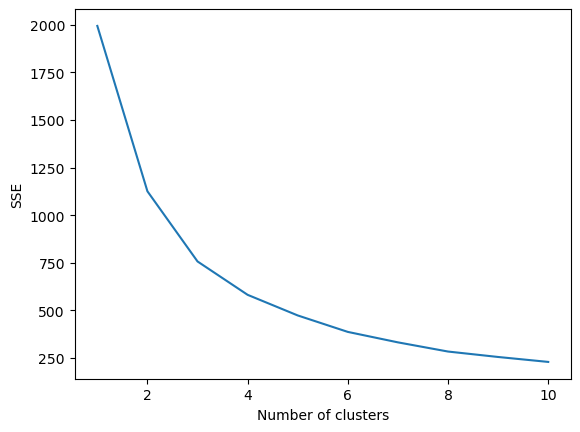

In [65]:
# Use elbow method to determine optimal number of clusters
SSE = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_df)
    SSE.append(kmeans.inertia_)

plt.plot(range(1, 11), SSE)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [66]:
# Create a k-means clustering model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)

# Fit the model to the data without the top1 column
kmeans.fit(pca_df)

# Create a new column in the original dataframe with the cluster labels from PCA and k-means clustering
df['cluster'] = kmeans.labels_

pca_df['cluster'] = kmeans.labels_

# Print the number of observations in each cluster
df['cluster'].value_counts().sort_index()


0    100
1    119
2     94
Name: cluster, dtype: int64

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

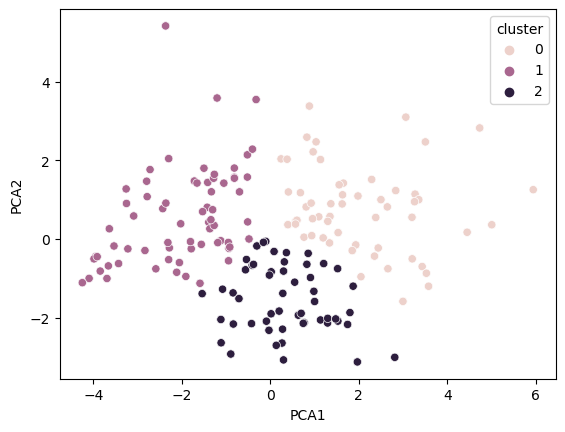

In [67]:
# Plot the clusters
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=pca_df)

In [79]:
# Group the data by cluster and calculate the mean of each feature
df.groupby('cluster').mean()




,wom,sm,walk,billboard,patronage,importantconvenience,importantvariety,importantprice,importanthealthy,importanttaste,...,chipotlehealthy,chipotletaste,chipotleambience,female,age,income,plan,spending,buylocal,healthyimportanttome
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.390000,0.120000,0.440000,0.000000,0.600000,4.090000,3.860000,4.280000,4.080000,4.84000,...,4.190000,4.150000,3.260000,0.330000,47.030000,50313.460000,2.110000,3.280000,2.030000,2.010000
1,0.521008,0.067227,0.445378,0.033613,0.184874,4.722689,4.596639,4.873950,4.773109,4.94958,...,4.899160,4.924370,4.546218,0.243697,37.436975,35751.899160,1.705882,2.739496,1.731092,1.495798
2,0.819149,0.042553,0.074468,0.000000,0.468085,4.638298,4.382979,4.829787,4.755319,5.00000,...,4.191489,3.893617,3.319149,0.053191,36.734043,38148.797872,1.702128,2.936170,1.723404,1.531915
